In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from utils.matrix import project_points, select_points_within_bounds
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh
from src.gaussian import GaussianSplatting


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
colmap_data = COLMAP_Data("data/sparse/0")
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

(56042, 3)


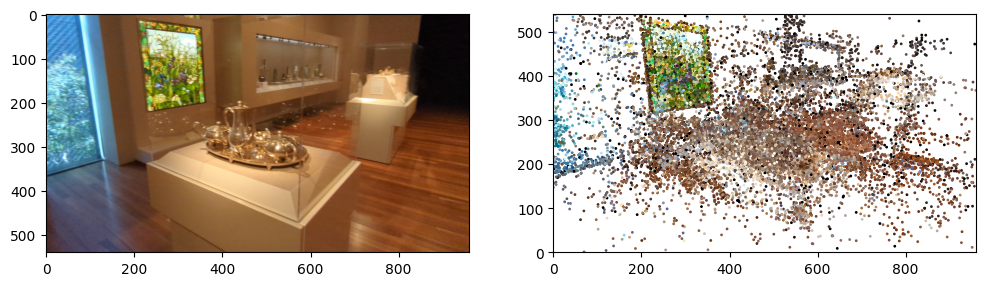

In [19]:
def project_points_to_image(data, idx):
    """
    Given frame index, project points to image and select points within image bounds
    """
    E, points, colors, K, distortion, (width, height), frame_names = data.E, data.points, data.colors, data.K, data.distortion, (data.width, data.height), data.frame_names

    e = E[frame_names[idx]]

    projected_points = project_points(points, e, K, distortion)
    bound_indices = np.all(projected_points >= 0, axis=1) & np.all(projected_points < [width, height], axis=1)

    bound_points = projected_points[bound_indices]
    bound_colors = colors[bound_indices]

    # invert y axis
    bound_points[:, 1] = height - bound_points[:, 1]
    return bound_points, bound_colors, bound_indices

i = 0
projected_points, projected_colors, bound_indices = project_points_to_image(colmap_data, i)

img = plt.imread(f"data/images/{colmap_data.frame_names[i]}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(img)
axs[0].set_aspect('equal')

axs[1].scatter(projected_points[:, 0], projected_points[:, 1], c=projected_colors, s=1)
axs[1].set_xlim(0, colmap_data.width)
axs[1].set_ylim(0, colmap_data.height)
axs[1].set_aspect('equal')
plt.show()

In [7]:
# Visualize covariance
viz_sigmas = sigmas/4
big_mesh = create_ellipsoids_as_one_mesh(model.points, viz_sigmas, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

In [8]:
"""
project covariance to image space

sigma` = JW Sigma W^T J^T

J = [[fx/z, 0, -fx*x/(z^2)]
    [0, fy/z, -fy*y/(z^2)]]
"""


e = colmap_data.E[colmap_data.frame_names[0]]
K = colmap_data.K
distortion = colmap_data.distortion
points = colmap_data.points

In [22]:
from utils.matrix import project_covariance
sigma_2d = project_covariance(points, sigmas/4, e, K)
bound_sigmas_2d = sigma_2d[bound_indices]

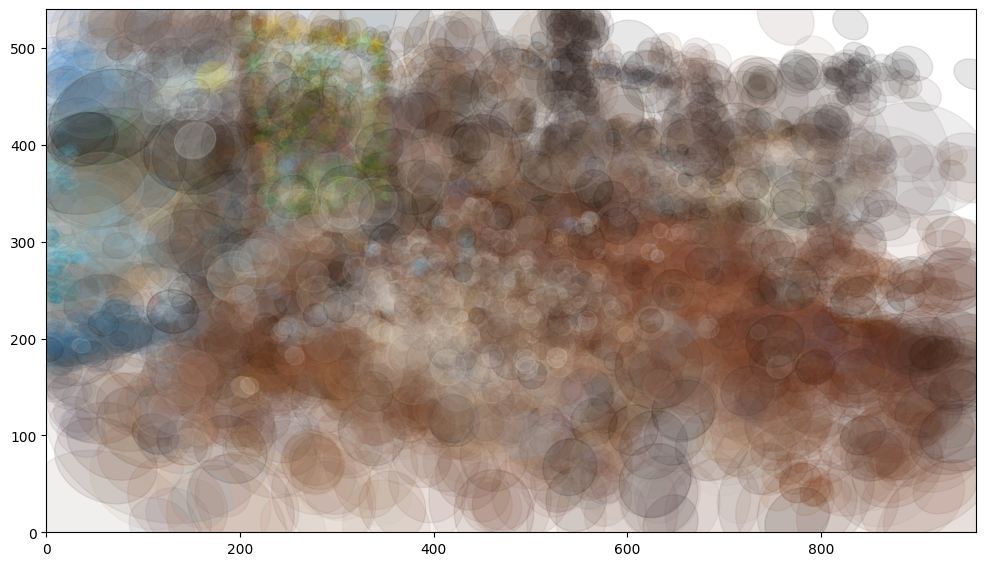

In [31]:
from matplotlib.patches import Ellipse
import numpy as np

def plot_cov_ellipse(cov, mean, ax, n_std=1.0, **kwargs):
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    
    # Angle between largest eigenvector and x-axis
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # Width and height are 2*n_std*sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(eigenvals)
    
    ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellip)
    return ellip

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(bound_sigmas_2d)):
    color = projected_colors[i]
    plot_cov_ellipse(bound_sigmas_2d[i], projected_points[i], ax, n_std=1, 
                     facecolor=color, edgecolor=color, alpha=0.1)

# ax.scatter(projected_points[:, 0], projected_points[:, 1], 
#           c=projected_colors, s=1, alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(0, colmap_data.width)
ax.set_ylim(0, colmap_data.height)
plt.show()

In [8]:
# To project covariance to image, apply differentiable tile rasterizer

"""
1. split screen into 16x16 pixel tiles.
2. cull gaussians
 - 99% confidence interval within bounds
 - extreme positions (near and far plane (?)) to avoid unstable 2D covariance
3. instantiate gaussian with hunber of tils they overlap (?)
4. assign each gaussian with key (view space depth, tile ID)
5. Radix sort with GPU (no per-pixel ordering)

6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)

"""

In [12]:
img_name = colmap_data.frame_names[i]
img = plt.imread(f"data/images/{img_name}")


In [16]:
tile = img[:16, :16]

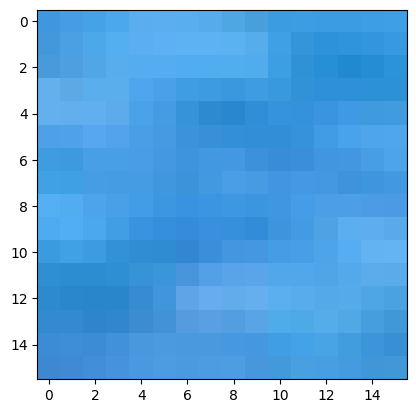

In [18]:
plt.imshow(tile)